<a href="https://colab.research.google.com/github/Craig-UK/artificial-intelligence/blob/main/StockPreBasedOffModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
!pip install pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [156]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [157]:
import pandas as pd
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as web

start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()

data = web.get_data_yahoo("ATVI", start, end)

data.to_csv("stock_data.csv")

[*********************100%***********************]  1 of 1 completed


In [158]:
data = pd.read_csv("stock_data.csv")

In [159]:
data = data[["Date", "Close"]]

In [160]:
data

,Date,Close
0,2020-01-02,58.650002
1,2020-01-03,58.669998
2,2020-01-06,59.740002
3,2020-01-07,60.340000
4,2020-01-08,59.880001
...,...,...
813,2023-03-27,84.330002
814,2023-03-28,84.349998
815,2023-03-29,84.540001
816,2023-03-30,84.889999


In [161]:
data.columns = ["ds", "y"]

In [162]:
data

,ds,y
0,2020-01-02,58.650002
1,2020-01-03,58.669998
2,2020-01-06,59.740002
3,2020-01-07,60.340000
4,2020-01-08,59.880001
...,...,...
813,2023-03-27,84.330002
814,2023-03-28,84.349998
815,2023-03-29,84.540001
816,2023-03-30,84.889999


In [163]:
from prophet import Prophet

In [164]:
prophet = Prophet(daily_seasonality=True)
prophet.fit(data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy48ejy5t/x_jm40th.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy48ejy5t/yla6g51p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92790', 'data', 'file=/tmp/tmpy48ejy5t/x_jm40th.json', 'init=/tmp/tmpy48ejy5t/yla6g51p.json', 'output', 'file=/tmp/tmpy48ejy5t/prophet_model4nk9van_/prophet_model-20230331143121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:31:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [165]:
future_dates = prophet.make_future_dataframe(periods=30)
predictions = prophet.predict(future_dates)

In [166]:
from prophet.plot import plot_plotly

plot_plotly(prophet, predictions)

In [167]:
pred_month = predictions["yhat"][-30:]

In [168]:
old_arr = []
full_arr = []
for x in pred_month:
  old_arr.append(x)
old_arr
for x in predictions["yhat"][-120:]:
  full_arr.append(x)


In [169]:
import numpy as np, numpy.random
value = np.random.dirichlet((5, 15), 30).transpose()
value *= 4

values = np.sort(value[0])
same_one = []

for i,x in enumerate(pred_month):
  if i == 0:
    same_one.append(x)
  else:
    same_one.append(x + values[i])
same_one
original_values = full_arr.copy()
full_arr[-30:] = same_one
print(value[0])
print(values)

[0.8650787  0.22339548 1.29600197 0.78112314 0.83998181 1.6309194
 1.39573875 0.54383451 1.1732882  0.68870568 1.06756103 1.09630446
 0.79273046 1.72715306 1.25393863 1.14854685 1.19045658 1.30337552
 0.95039594 1.16430986 0.89981686 1.50881233 0.6881456  2.42350587
 0.63500993 0.78649035 0.98284725 1.16985843 0.81224706 1.33189429]
[0.22339548 0.54383451 0.63500993 0.6881456  0.68870568 0.78112314
 0.78649035 0.79273046 0.81224706 0.83998181 0.8650787  0.89981686
 0.95039594 0.98284725 1.06756103 1.09630446 1.14854685 1.16430986
 1.16985843 1.1732882  1.19045658 1.25393863 1.29600197 1.30337552
 1.33189429 1.39573875 1.50881233 1.6309194  1.72715306 2.42350587]


<Axes: >

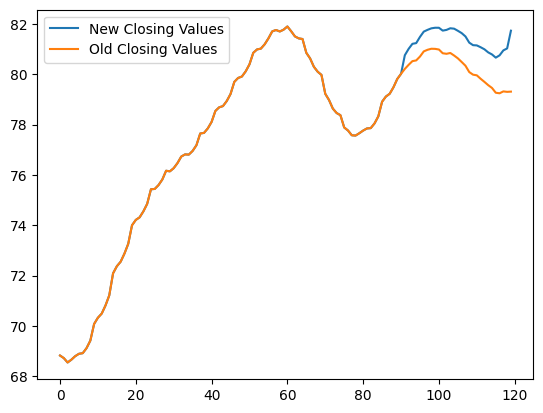

In [170]:
new_preds = pd.DataFrame(full_arr, columns = ["New Closing Values"])
old_preds = pd.DataFrame(original_values, columns = ["Old Closing Values"])
df_merged = pd.concat([new_preds, old_preds], axis=1)
df_merged
df_merged.plot()

In [171]:
start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()
data = web.get_data_yahoo("GOOG", start, end)
data.to_csv("stock_data.csv")
data = pd.read_csv("stock_data.csv")
print(data)
data = data[["Date", "Close"]]
prophet = Prophet(daily_seasonality=True)
data.columns = ["ds", "y"]
prophet.fit(data[:-100])
future_dates = prophet.make_future_dataframe(periods=100)
predictions = prophet.predict(future_dates)
plot_plotly(prophet, predictions)
real = data["y"][-100:]
predict = predictions["yhat"][-100:]
if sum(real) > sum(predict):
  total = ((sum(real) - sum(predict)) / sum(real)) * 100
  #print(total)
else:
  total = ((sum(predict) - sum(real)) / sum(predict)) * 100
  #print(total)
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
print(smape(real, predict))

[*********************100%***********************]  1 of 1 completed

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy48ejy5t/58ys5im0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy48ejy5t/w1fvtyjw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5658', 'data', 'file=/tmp/tmpy48ejy5t/58ys5im0.json', 'init=/tmp/tmpy48ejy5t/w1fvtyjw.json', 'output', 'file=/tmp/tmpy48ejy5t/prophet_modelza_p80o7/prophet_model-20230331143122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:31:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



           Date        Open        High         Low       Close   Adj Close  \
0    2020-01-02   67.077499   68.406998   67.077499   68.368500   68.368500   
1    2020-01-03   67.392998   68.625000   67.277199   68.032997   68.032997   
2    2020-01-06   67.500000   69.824997   67.500000   69.710503   69.710503   
3    2020-01-07   69.897003   70.149498   69.518997   69.667000   69.667000   
4    2020-01-08   69.603996   70.579002   69.542000   70.216003   70.216003   
..          ...         ...         ...         ...         ...         ...   
813  2023-03-27  105.320000  105.400002  102.629997  103.059998  103.059998   
814  2023-03-28  103.000000  103.000000  100.279999  101.360001  101.360001   
815  2023-03-29  102.720001  102.820000  101.029999  101.900002  101.900002   
816  2023-03-30  101.440002  101.610001  100.290001  101.320000  101.320000   
817  2023-03-31  101.709999  102.989998  101.440002  102.889999  102.889999   

       Volume  
0    28132000  
1    23728000  
2 

14:31:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


11.439380211823913
